# Translation with a Sequence to Sequence Network and Attention

Training a neural network to convert a German Sentence to English Sentence.

Notes :  
This is made possible by the simple yet powerful idea of the sequence to sequence network, in which two recurrent neural networks work together to transform one sequence to another sequence. An `encoder` network condenses an input sequence into a vector, and a `decoder` network unfolds that vector into a new sequence.

<img src = 'https://pytorch.org/tutorials/_images/seq2seq.png'/>

To improve upon this model we will use an `attention mechanism`, which lets the decoder learn to focus over a specific range of the input sequence.

### Importing Requirements

In [1]:
from __future__ import unicode_literals, division, print_function
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Loading Data Files**

The data for this project is collection og English to German translation pairs.  
Thanks to <a href = 'http://www.manythings.org/anki/'> here </a> for providing the data.  
The data for this is available at data/eng-deu.txt. The file is a tab separated list of translation pairs:  
  
I ran. &emsp; Ich rannte.
  
We will be representing each word in a language as a one-hot vector, or giant vector of zeros except for a single one (at the index of the word). Compared to the dozens of characters that might exist in a language, there are many many more words, so the encoding vector is much larger. We will however cheat a bit and trim the data to only use a few thousand words per language.

We’ll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called `Lang` which has `word → index` (word2index) and `index → word` (index2word) dictionaries, as well as a count of each word `word2count` to use to later replace rare words.

In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.index2word = {0 : 'SOS', 1 : 'EOS'}
        self.word2count = {}
        self.n_words = 2 # count for SOS and EOS
    
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
# The files are in Unicode strings therefore to simplify converting these 
# string to ASCII format, trim punctuations and convert them in lower case

def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

# Lowercase, trim and remove non-letter characters
def normalizeString(s):
    s = strip_accents(s.lower().strip())
    s = re.sub(r'([.!?])', r'\1', s)
    s = re.sub(r'[^a-zA-z.!?]+', r' ', s)
    return s

To read the data file we will spilt the content of file in lines and then into pairs. The files are all `English -->> German`, so if we want to translate from `German -->> English` then can use the reversed flag. 

In [4]:
def readlangs(lang1, lang2, reverse = False):
    print('-' * 100)
    print('Reading lines .....')
    print('-' * 100)
    
    # Reading lines and Splitting it into pairs
    with open('data/{}-{}.txt'.format(lang1, lang2), encoding = 'utf-8') as f:
        lines = f.read().strip().split('\n')
        
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

First let's do some experimentation talking sentences with max length of 10. With a few more filtering applied

In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    'i am', 'i m',
    'he is', 'he s',
    'she is', 'she s',
    'you are', 'you re',
    'we are', 'we re',
    'they are', 'they re',
    'it is', 'it s',
    'i will', 'i ll',
    'let us', 'let s',
    'we will', 'we ll',
    'do not', 'don t',
    'here is', 'here s',
    'i would', 'i d',
    'what is', 'what s',
    'who will', 'who ll',
    'that will', 'that ll',
    'that is', 'that s',
    'this will' ,'this ll',
    'you have', 'you ve',
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
           len(p[1].split(' ')) < MAX_LENGTH and \
           p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

**Describing the text processing steps**
  
The full process of text preperation is as follows:
 - Read text file and split it into lines, split lines into pairs
 - Normalize text, filter by length and content
 - Make word lists from sentences in pairs 

In [6]:
def prepareData(lang1, lang2, reverse = False):
    input_lang, output_lang, pairs = readlangs(lang1, lang2, reverse)
    print('Read {} sentence pairs.'.format(len(pairs)))

    pairs = filterPairs(pairs)
    print('Trimmed to {} number of pairs.'.format(len(pairs)))
    
    print('-' * 100)
    print('Counting of word is starting .....')
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print('Counted Words Stats : ')
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    print('-' * 100)
    
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'deu', True)
print(random.choice(pairs))

----------------------------------------------------------------------------------------------------
Reading lines .....
----------------------------------------------------------------------------------------------------
Read 169813 sentence pairs.
Trimmed to 26905 number of pairs.
----------------------------------------------------------------------------------------------------
Counting of word is starting .....
Counted Words Stats : 
deu 11972
eng 7243
----------------------------------------------------------------------------------------------------
['es ist noch immer uberfullt.', 'it s still crowded.']


### The Sequence to Sequence Model
  
A Recurrent Neural Network rather RNN is a neural network that operates on a sequence and uses its own output as input for subsequent time steps.
  
A `Sequence to Sequence network` or seq2seq network or `Encoder Decoder Network`, is a model consisting of two RNN called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.
  
Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.
  
With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the "meaning" of the input sequence into a single vector - a single point in some N dimensional space of sentences.
This single vector is often called as `context vector`.

**The Encoder**
  
The Encoder of a seq2seq model is a RNN that output some kind of value for every word from the input sentence. For every input it outputs a vector and a hidden state which in turn will be used as input for next word. 
  
The diagram for illustrating the above written description is shown below:
  
<img src = 'https://pytorch.org/tutorials/_images/encoder-network.png'/>

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
            
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device = device)

**The Decoder**  
The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.
  
<b>Simple Decoder</b>  
In the simplest se2seq decoder we use only last output of the encoder. This last output is sometimes called as the `context vector` as it encodes context from the entire sequence. This context vector is used  as the initial hidden state of the decoder.
  
At every step of the decoding, the decoder is given an input tokken and hidden state. The initial input token is `<sos>` token, and the first hidden state is the context vector (the encoder's last hidden state).

<img src = 'https://pytorch.org/tutorials/_images/decoder-network.png'/>

In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
        self.lin = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.lin(output[0])
        output = self.softmax(output)
        
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device = device)        

<b>Attention Decoder</b>
  
If only the context vector is passed between the encoder and decoder, that single vector carries the burden of encoding the entire sentence.
  
Attention allows the decoder network to "focus" on a different part of the encoder's output for every time step for decoder's output. For this we need to calculate a set of attention weights. These weights will be multiplied with the encoder's output vector to create a weighted combination. The result should contains the information about that specific part of the input sequence, and thus help the decoder choose the right output words.
  
<img src = 'https://i.imgur.com/1152PYf.png'/>
  
Calculating the attention weights is carried out by another feed forward neural network setup that takes in input the output of the Encoder (which will serve as input for the decoder) and the previous hidden state of the Decoder Network and then passed through a softmax gate. The resultant of this gate serve as the attention vector for the ith input and the t-th output. The weights are calculated in such a fashion that all the attention vector calculated for getting the t-th output when summed uo will result in a unit vector.

The graph for such a Attention based RNN is shown below :
  
<img src = 'https://pytorch.org/tutorials/_images/attention-decoder-network.png'/>
  

In [9]:
class AttentionDecoderRNN(nn.Module):
    """
    Attention Based Decoder RNN
    
    ARGS:
     -> hidden_size - type : int - number of hidden dimensions
     -> output_size - type : int - output size
     -> dropout_p - type : float - the dropout percentage
     -> max_length - type : int - the maximum permissible length of the sentences
    """
    def __init__(self, hidden_size, output_size, 
                 dropout_p = 0.1, max_length = MAX_LENGTH):
        super(AttentionDecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combined = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        attn_out = self.attn(torch.cat((embedded[0], hidden[0]), 1))
        attn_weights = F.softmax(attn_out, dim = 1)
        
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), 
                                 encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combined(output).unsqueeze(0)
        output = F.relu(output)
        
        output, hidden = self.gru(output, hidden)
        output = self.out(output[0])
        
        output = F.log_softmax(output, dim = 1)
        
        return output, hidden, attn_weights
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device = device)

## Training
  
**Preparing Training Data**  
  
To train, for each pair we will need an input tensor (indexes of words in the input sentence) and target tensor (indexes of words in the target sentence). While Creating both the tensors we will create the EOS token to both the sequences.

In [10]:
def indexesFromSentences(lang, sentences):
    return [lang.word2index[word] for word in sentences.split(' ')]

def tensorFromSentences(lang, sentences):
    indexes = indexesFromSentences(lang, sentences)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype = torch.long, device = device).view(-1, 1)

def tensorFromPair(pair):
    input_tensor = tensorFromSentences(input_lang, pair[0])
    target_tensor = tensorFromSentences(output_lang, pair[1])    
    return(input_tensor, target_tensor)

**Training the Model**
  
To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state.  Then the decoder is given the `<sos>` token as its first input, and the last hidden state of the encoder as its first hidden state.

`"Teacher Forcing"` is the concept of using the real target output as input to the next step, instead of using the decoder's guess as the next input. Using Teacher Forcing causes model to converge faster but when the trained model is exploited, it may exhibit instability.
  
You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - intuitively it has learned to represent the output grammar and can “pick up” the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation in the first place.

Because of the freedom PyTorch’s autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement. Turn `teacher_forcing_ratio` up to use more of it.

In [11]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion, max_length = MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device = device)
    
    loss = 0
    
    for encod_in in range(input_length):
        encoder_output, encoder_hidden = encoder(
                                    input_tensor[encod_in], encoder_hidden)
        
        encoder_outputs[encod_in] = encoder_output[0, 0]
    
    decoder_input = torch.tensor([[SOS_token]], device = device)
    
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Using teacher forcing feeding the target tensor as input
        # rather then its own guess
        for decod_in in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                         decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[decod_in])
            decoder_input = target_tensor[decod_in] # teacher facing
        
    else:
        # With out teacher forcing using its on guess as input
        for decod_in in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                        decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[decod_in])
            
            # Getting the top k guess of decoder
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach() # detachinf it from the history
            
            if decoder_input.item == EOS_token:
                break
        
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

Below is a helper function to print time elapsed and estimated time remaining given the current time and progress in percentages.

In [12]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '{}m {}s'.format(m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return '{} (- {})'.format(asMinutes(s), asMinutes(rs))

The whole training process looks like :
- Start timer
- Initialize optimizers and criterions
- Create set of training pairs
- Start empty losses array for plotting
  
Then we will invoke `train()` several times and eventually will print the progress (percent of examples, time so far, estimated time) and average loss

In [13]:
def trainIters(encoder, decoder, n_iters, print_every = 100,
               plot_every = 100, learning_rate = 0.01):
    """
        This function will kick off the training procedure and train the enitire Seq2Seq network.
        At a wild level, this will take the arguments and invoke the train() passing the arguments
        Also will print stats related to training phase like avaerage loss and plot graph based on 
        arguments specified.
        
        ARGS :
        # encoder - reference to encoder class.
        # decoder - reference to decoder class.
        # n_ters - number of iteration to do for training network.
        # print_every, plot_every - number of iteration after which to print and plot stats respectively.
        # learning_rate : learning rate for the network.
    """
    # Step 1 : Starting timer
    start = time.time()
    
    # Step 2: Initialize optimizers and criterion
    encoder_optimizer = optim.SGD(encoder.parameters(), lr = learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr = learning_rate)
    
    criterion = nn.NLLLoss()
    
    # Step 3: Creating sets of training pairs
    training_pairs = [tensorFromPair(random.choice(pairs))
                      for _ in range(n_iters)]
    
    # Step 4: Start empty losse array for plotting
    plot_losses = []
    print_loss_total = 0 # Resets every print_every
    plot_loss_total = 0 # Resets every plot_every
    
    # Kicking off the Training
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion)
        
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

**Plotting Results**
  
Plotting is done using matplotlib, using the array of loss values `plot_losses` saved during the training.

In [14]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

In [15]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at multiple places
    loc = ticker.MultipleLocator(base = 0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

**Evalutaion**
  
Evaluation is same mostly as the training, but there are no targets so we simply feed the decoder's prediction back to itself for each step. Every time it predicts a word we will add it to output strings, and if predicts EOS token we stop there. We also store the decoder's attention output for display later.

In [16]:
def evaluate(encoder, decoder, sentence, max_length = MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentences(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device = device)
        
        for encod_in in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[encod_in], 
                                                     encoder_hidden)
            encoder_outputs[encod_in] = encoder_output[0, 0]
            
        decoder_input = torch.tensor([[EOS_token]], device = device)
        
        decoder_hidden = encoder_hidden
        
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        for decod_in in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                        decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[decod_in] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            
            decoder_input = topi.squeeze().detach()
        
        return decoded_words, decoder_attentions[:decod_in + 1]

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [17]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('-' * 100)
        print('Sentence : ', pair[0])
        print('Actual Translation : ', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('Machine Translation : ', output_sentence)
        print('')
        print('-' * 100)

**Training and Evaluating**

For the filtered dataset we will use a small network of 260 hidden nodes and a single GRU layer. Let's see how much time it will take on a system with following specifications:
  
- Processor : Intel® Core™ i5-4440S CPU @ 2.80GHz × 4 
- Memory : 15.5 GiB
- OS : 64-bit Ubuntu 18.04 LTS
  
on CPU based training machine.

7m 26.412492752075195s (- 104m 9.774898529052734s) (5000 6%) 4.3668
14m 41.98806571960449s (- 95m 32.9224271774292s) (10000 13%) 3.5856
21m 56.54452610015869s (- 87m 46.178104400634766s) (15000 20%) 3.3414
29m 9.825998067855835s (- 80m 12.021494686603546s) (20000 26%) 3.1016
36m 41.650166749954224s (- 73m 23.300333499908447s) (25000 33%) 2.9030
44m 30.875381231307983s (- 66m 46.313071846961975s) (30000 40%) 2.7611
52m 30.03575372695923s (- 60m 0.040861402238988376s) (35000 46%) 2.5932
61m 14.68447732925415s (- 53m 35.34891766309738s) (40000 53%) 2.5067
69m 39.64542293548584s (- 46m 26.430281956991166s) (45000 60%) 2.3987
77m 35.30624866485596s (- 38m 47.65312433242798s) (50000 66%) 2.3215
86m 44.438069581985474s (- 31m 32.52293439344976s) (55000 73%) 2.2230
94m 47.121703147888184s (- 23m 41.780425786972046s) (60000 80%) 2.1422
103m 33.53949165344238s (- 15m 55.92915256206743s) (65000 86%) 2.0712
112m 2.0104262828826904s (- 8m 0.14360187734837382s) (70000 93%) 2.0436
120m 22.20773887634

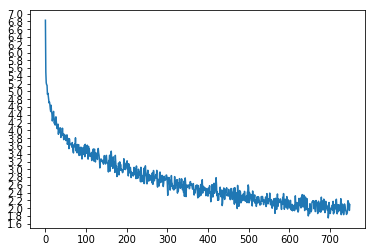

In [18]:
hidden_size = 260
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttentionDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

**Lets Evaluate it using Random pairs**

In [19]:
evaluateRandomly(encoder1, attn_decoder1)

----------------------------------------------------------------------------------------------------
Sentence :  ich werde mich zukunftig um meine eltern kummern.
Actual Translation :  i will look after my parents in the future.
Machine Translation :  i will take care of my parents. <EOS>

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Sentence :  er ist uber die ma en glucklich.
Actual Translation :  he s extremely happy.
Machine Translation :  she is almost to the <EOS>

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Sentence :  ich habe tom einen gefallen getan.
Actual Translation :  i did tom a favor.
Machine Translation :  i did tom a <EOS>

-----------------------------------

**Visualizing Attention**
  
A useful property of attention mechanism is its highly interpretable outputs. Beacause it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.
  
You could simply run `plt.matshow(attentions)` to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

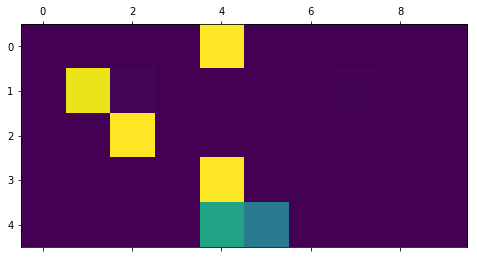

In [20]:
output_words, attentions = evaluate(
            encoder1, attn_decoder1, 'ich fuhle mich hungrig.')
plt.matshow(attentions)

For a better viewing experience, let's do some extra bit of work by adding axes and labels:

input = sie ist junger als ich
output = she is younger than i thought. <EOS>


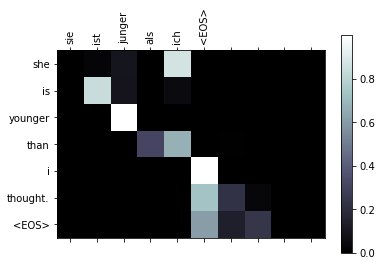

input = sie ist zu klein.
output = she is too late. <EOS>


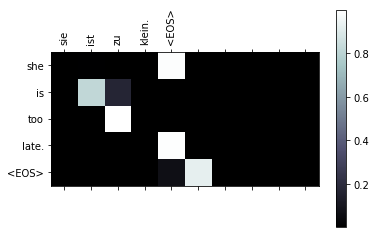

input = ich habe keine angst zu sterben.
output = don t afraid afraid <EOS>


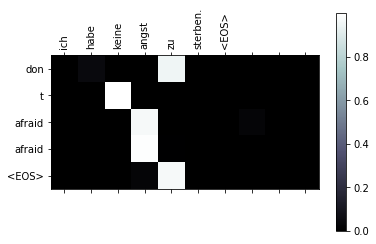

input = er ist ein talentierter junger regisseur.
output = s a a big <EOS>


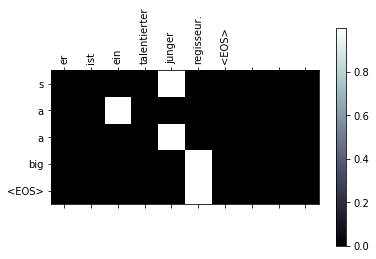

In [21]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("sie ist junger als ich")
evaluateAndShowAttention("sie ist zu klein.")
evaluateAndShowAttention("ich habe keine angst zu sterben.")
evaluateAndShowAttention("er ist ein talentierter junger regisseur.")

**DONE ! . . . . .**